In [1]:
#!/usr/bin/env python3
"""
DHN Performance Toolkit - Main Analysis Script
==============================================

District Heating Network performance analysis with:
- COP & Energy Analysis  
- Velocity Analysis
- Automated Reporting

Usage:
    1. Copy config_template.py to config_local.py
    2. Adjust paths in config_local.py
    3. Run: python main_analysis.py
"""

# Try to import local config, fallback to template
try:
    from config_local import SCENARIOS, DEFAULT_PARAMS
    print("✅ Using local configuration")
except ImportError:
    print("⚠️ config_local.py not found - using template")
    print("💡 Copy config_template.py to config_local.py and adjust paths")
    from config_template import SCENARIOS, DEFAULT_PARAMS



✅ Using local configuration


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# UESGraphs
from uesgraphs.uesgraph import UESGraph
import uesgraphs.analyze as analyze

In [3]:
from modules.decentral_pump_power import calculate_decentral_pump_energy

In [4]:
# Select scenario
scenario_key = "Scenario 1"  # Adjust this
scenario = SCENARIOS[scenario_key]

print(f"📋 Analyzing: {scenario['name']}")
print(f"📂 Output: {scenario['output_dir']}")

📋 Analyzing: Analysis 1
📂 Output: E:\rka_lko\work\2025_06_Hassel_simulation_analysis\Prio1_npro_complete_sfh\outputs


In [5]:
# Data Loading Functions
def get_dataframe(mask, file_path, uesgraph):
    """Load data for a specific mask pattern"""
    filter_list = []
    for node in uesgraph.nodelist_building:
        if not uesgraph.nodes[node]["is_supply_heating"]:
            name_bldg = uesgraph.nodes[node]["name"]
            filter_pattern = mask.format(name_bldg=name_bldg)
            filter_list.append(filter_pattern)
    
    df = analyze.process_simulation_result(file_path=file_path, filter_list=filter_list)
    df = analyze.prepare_DataFrame(
        df, 
        base_date=datetime.strptime(DEFAULT_PARAMS["start_date"], "%Y-%m-%d"), 
        end_date=datetime.strptime(DEFAULT_PARAMS["end_date"], "%Y-%m-%d"),
        time_interval=DEFAULT_PARAMS["time_interval"]
    )
    
    # Simplify column names
    import re
    pattern = re.compile(r'T([^.]+)')
    new_columns = []
    for col in df.columns:
        match = pattern.search(col)
        if match:
            new_columns.append(f"T{match.group(1)}")
        else:
            new_columns.append(col)
    df.columns = new_columns
    
    return df

# Load UESGraph
uesgraph = UESGraph()
uesgraph.from_json(path=scenario["json_path"], network_type="heating")
print(f"✅ Network loaded: {len(uesgraph.nodes)} nodes, {len(uesgraph.edges)} edges")

read nodes...
******
 input_ids were {'buildings': None, 'nodes': '5f4c976f-bea3-476b-875b-c4d08dfc2057', 'pipes': None, 'supplies': None}
...finished
✅ Network loaded: 68 nodes, 67 edges


In [6]:
# Load pump power data
PUMP_MASK = 'networkModel.demandT{name_bldg}.simplePumpConstFlow.pumpHeating.P$'
df_pump_power = get_dataframe(PUMP_MASK, scenario["data_path"], uesgraph)

print(f"📊 Pump data loaded: {df_pump_power.shape}")
print(f"📊 Buildings: {list(df_pump_power.columns)}")
# Run pump analysis using the module
pump_results = calculate_decentral_pump_energy(
    df_pump_power, 
    output_dir=scenario["output_dir"],
    store_result=True,
)


Processing: E:\rka_lko\work\2025_06_Hassel_simulation_analysis\Prio1_npro_complete_sfh\Sim20250612_154050_1\Results\Sim20250612_154050_1_inputs.gzip
📊 Pump data loaded: (35041, 32)
📊 Buildings: ['T56_wa2b_efh2', 'T54_wa2b_efh1', 'T48_wa2b_rhh3_2', 'T50_wa2b_rhh3_3', 'T44_wa2b_dhh6_1', 'T42_wa2b_dhh6_2', 'T58_wa2b_dhh3_1', 'T36_wa2b_dhh3_2', 'T38_wa2b_dhh4_1', 'T40_wa2b_dhh4_2', 'T42_wa2b_dhh2_1', 'T34_wa2b_dhh2_2', 'T32_wa2b_rhh2_1', 'T30_wa2b_rhh2_2', 'T28_wa2b_rhh2_3', 'T27_wa3_dhh1_1', 'T25_wa3_dhh1_2', 'T23_wa3_rhh1_2', 'T21_wa3_rhh1_3', 'T37_wa3_dhh3_1', 'T35_wa3_dhh3_2', 'T33_wa3_dhh2_1', 'T29_wa3_dhh2_2', 'T43_wa3_dhh5_1', 'T41_wa3_dhh5_2', 'T45_wa3_dhh6_1', 'T49_wa3_rhh2_2', 'T47_wa3_rhh2_3', 'T26_wa2b_rhh1_1', 'T24_wa2b_rhh1_2', 'T22_wa2b_rhh1_3', 'T18_wa2b_dhh1_1']


KeyboardInterrupt: 

In [9]:
from modules.heat_pump_analyzer import *
import os

In [14]:
# HP Power & Energy Analysis

# Load HP and thermal data
HP_POWER_MASK = 'networkModel.demandT{name_bldg}.heatPumpFixDeltaT.heaPum.P$'
THERMAL_MASK = 'networkModel.demandT{name_bldg}.heatPumpFixDeltaT.heaPum.QCon_flow$'

df_hp_power = get_dataframe(HP_POWER_MASK, scenario["data_path"], uesgraph)
df_thermal = get_dataframe(THERMAL_MASK, scenario["data_path"], uesgraph)

print(f"📊 HP Power data: {df_hp_power.shape}")
print(f"📊 Thermal data: {df_thermal.shape}")


Processing: E:\rka_lko\work\2025_06_Hassel_simulation_analysis\Prio1_npro_complete_sfh\Sim20250612_154050_1\Results\Sim20250612_154050_1_inputs.gzip
Processing: E:\rka_lko\work\2025_06_Hassel_simulation_analysis\Prio1_npro_complete_sfh\Sim20250612_154050_1\Results\Sim20250612_154050_1_inputs.gzip
📊 HP Power data: (35041, 32)
📊 Thermal data: (35041, 32)


In [15]:

# Monthly energy analysis using your imported functions
monthly_energy, annual_stats = analyze_monthly_energy_cop(
    df_thermal_power=df_thermal,
    df_hp_electrical_power=df_hp_power, 
    df_pump_electrical_power=df_pump_power,  # From previous cell
    time_interval_hours=DEFAULT_PARAMS["time_interval_hours"],
    save_path=os.path.join(scenario["output_dir"], "monthly_energy_analysis.csv")
)


Converting power to energy using 0.25h intervals...

MONTHLY ENERGY-BASED COP ANALYSIS
Month      Thermal    Electrical   COP    COP(HP)  Activity
           [MWh]      [MWh]               only     [%]     
--------------------------------------------------------------------------------
January    36465.5    8239.3       4.43   4.53     51.6    
February   30856.1    7109.2       4.34   4.43     45.4    
March      25094.6    5940.2       4.22   4.31     31.5    
April      15862.2    3990.5       3.98   4.05     16.8    
May        10233.1    2871.3       3.56   3.80     6.9     
June       8670.1     2525.9       3.43   3.79     5.2     
July       8378.2     2447.4       3.42   3.85     4.9     
August     8170.8     2372.6       3.44   3.83     4.8     
September  8426.8     2294.0       3.67   3.85     5.5     
October    16450.4    3742.5       4.40   4.48     19.0    
November   28157.8    6176.6       4.56   4.67     41.7    
December   36484.4    8065.5       4.52   4.63     5

In [17]:
from typing import List

def save_dataframes_to_excel(
    dataframes: Dict[str, pd.DataFrame],
    file_path: str,
    index: bool = True,
    float_format: Optional[str] = None,
    sheet_order: Optional[List[str]] = None
) -> None:
    """
    Speichert mehrere DataFrames in einer Excel-Datei, wobei jeder DataFrame ein eigenes Sheet erhält.
    
    Parameters
    ----------
    dataframes : Dict[str, pd.DataFrame]
        Dictionary mit Sheet-Namen als Schlüssel und DataFrames als Werte
    file_path : str
        Pfad zur Excel-Datei
    index : bool, default True
        Ob der Index der DataFrames mitgespeichert werden soll
    float_format : Optional[str], default None
        Format für Fließkommazahlen (z.B. '%.2f' für 2 Dezimalstellen)
    sheet_order : Optional[List[str]], default None
        Liste mit Sheet-Namen in der gewünschten Reihenfolge
        
    Returns
    -------
    None
    
    Examples
    --------
    >>> df1 = pd.DataFrame({'A': [1, 2], 'B': [3, 4]})
    >>> df2 = pd.DataFrame({'X': [10, 20], 'Y': [30, 40]})
    >>> save_dataframes_to_excel({'Sheet1': df1, 'Sheet2': df2}, 'output.xlsx')
    """
    # Verzeichnis erstellen, falls es nicht existiert
    os.makedirs(os.path.dirname(os.path.abspath(file_path)), exist_ok=True)
    
    # ExcelWriter erstellen
    with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
        # Falls eine bestimmte Reihenfolge gewünscht ist
        if sheet_order:
            # Sicherstellen, dass alle Sheets in sheet_order enthalten sind
            missing_sheets = set(dataframes.keys()) - set(sheet_order)
            if missing_sheets:
                sheet_order.extend(missing_sheets)
            
            # DataFrames in der angegebenen Reihenfolge speichern
            for sheet_name in sheet_order:
                if sheet_name in dataframes:
                    dataframes[sheet_name].to_excel(
                        writer, 
                        sheet_name=sheet_name, 
                        index=index,
                        float_format=float_format
                    )
        else:
            # DataFrames ohne bestimmte Reihenfolge speichern
            for sheet_name, df in dataframes.items():
                df.to_excel(
                    writer, 
                    sheet_name=sheet_name, 
                    index=index,
                    float_format=float_format
                )

save_dataframes_to_excel(
    {
        "HP electric power": df_hp_power,
        "HP Q cond": df_thermal,
        "Pump Results": df_pump_power,
    },
    os.path.join(scenario["output_dir"], "analysis_results.xlsx"),
    index=True,
    float_format="%.2f",
    sheet_order=["Monthly Energy Analysis", "Annual Statistics", "Pump Results"]
)

Exception ignored in: <function ZipFile.__del__ at 0x00000206A8435B20>
Traceback (most recent call last):
  File "e:\rka_lko\conda\envs\uesgraphs1\Lib\zipfile\__init__.py", line 1988, in __del__
    self.close()
  File "e:\rka_lko\conda\envs\uesgraphs1\Lib\zipfile\__init__.py", line 2005, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


In [ ]:

plot_monthly_energy_analysis(monthly_energy, save_path=os.path.join(scenario["output_dir"], "monthly_energy_analysis.png"))

In [21]:
import uesgraphs.analyze as analyze
uesgraph.graph["supply_type"] = "supply"
analyze.assign_data_to_uesgraphs(uesgraph,
                                scenario["data_path"],
                                start_date=DEFAULT_PARAMS["start_date"], 
                                end_date=DEFAULT_PARAMS["end_date"],
                                time_interval=DEFAULT_PARAMS["time_interval"])


Processing: E:\rka_lko\work\2025_06_Hassel_simulation_analysis\Prio1_npro_complete_sfh\Sim20250612_154050_1\Results\Sim20250612_154050_1_inputs.gzip
Assignment of pressure to nodes completed


<uesgraphs.UESGraph object>

In [31]:
#
#import modules.utils as ut
#ut.load_pipe_catalog(custom_path="data")

In [34]:

import modules.velocity as velocity
import importlib
importlib.reload(velocity)

analyzed_graph = velocity.velocity_analysis_pipeline(uesgraph,catalog=r"data\isoplus.csv")

modules.velocity.plot_velocity_vs_diameter_simple - INFO - Plotting 67 pipes, max diameter: 236.6mm
modules.velocity.plot_velocity_vs_diameter_simple - INFO - Plot saved to: E:\rka_lko\work\2025_06_Hassel_simulation_analysis\Prio1_npro_complete_sfh\outputs\velocity_diameter_plot.png


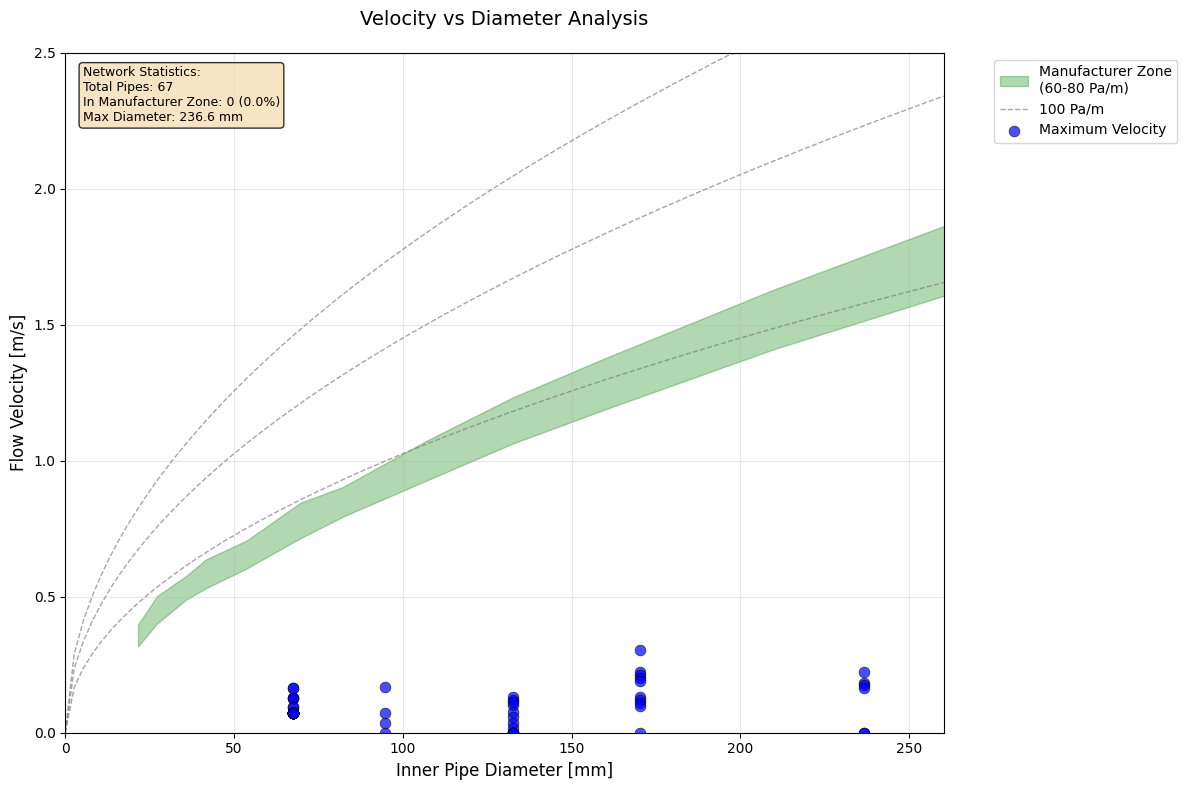

modules.velocity.plot_velocity_vs_diameter_simple - INFO - Plot completed: 0/67 pipes in manufacturer zone


In [35]:

velocity.plot_velocity_vs_diameter_simple(graph=analyzed_graph,
                                      catalog=r"data\isoplus.csv",
                                      save_path=os.path.join(scenario["output_dir"], "velocity_diameter_plot.png"),
                                      max_velocity=2.5,
                                      velocity_metrics = ["max"]
                                      )

In [32]:
analyzed_graph.graph["name"] = "Hassel"
velocity.plot_network_velocity_analysis(
    analyzed_graph,
    save_path=os.path.join(scenario["output_dir"], "velocity_analysis_cum_min"),
    analysis_metric="cum_error",
    constraint_type="min"
)

Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\2\Visuals_20250622_232828.log


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


In [ ]:
velocity.plot_velocity_time_series(
    analyzed_graph,
    save_path=os.path.join(scenario["output_dir"], "velocity_time_series.png"),
    analysis_metric="cum_error",
    constraint_type="min"
)

Found 67 edges with velocity data


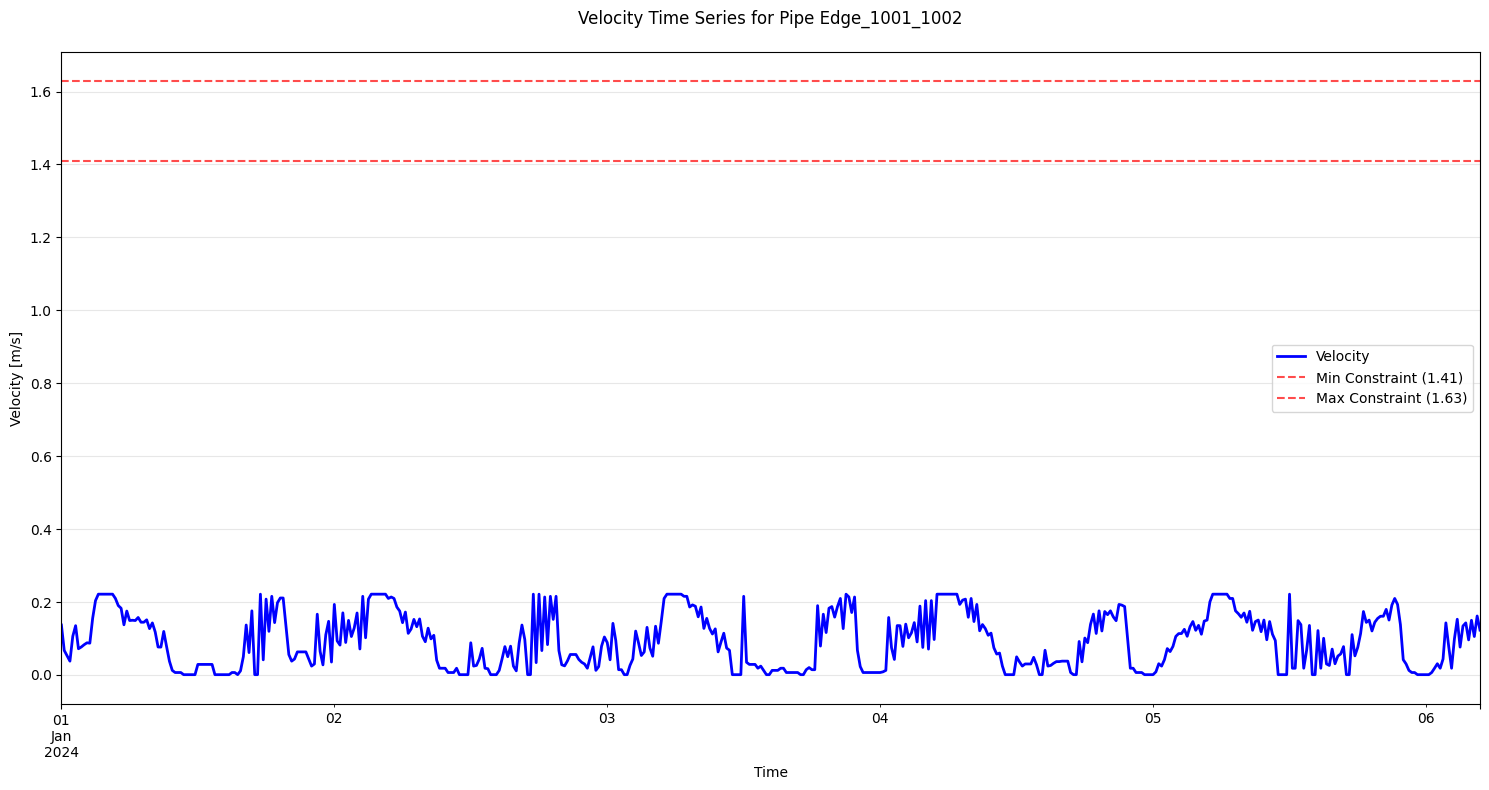

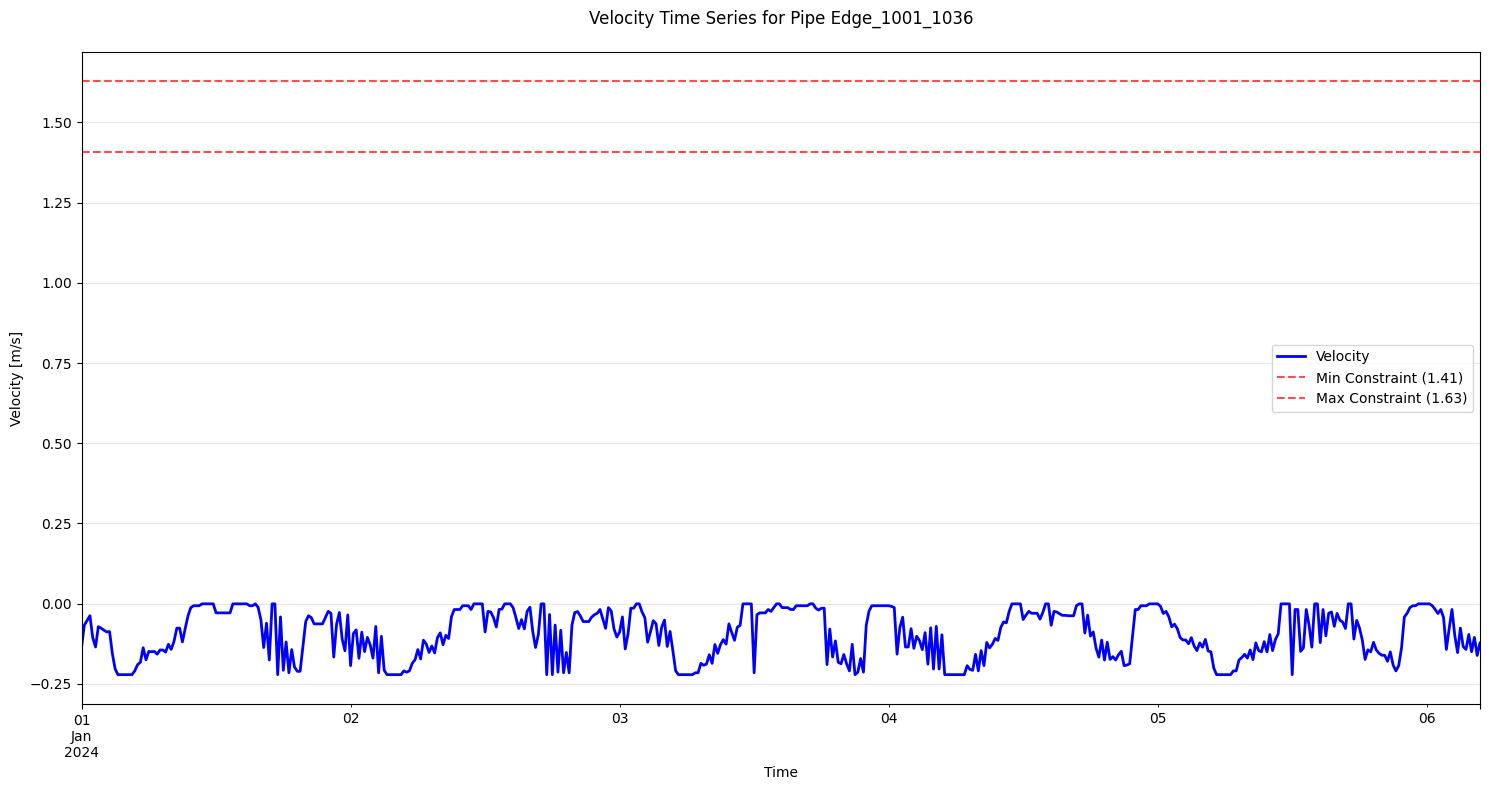

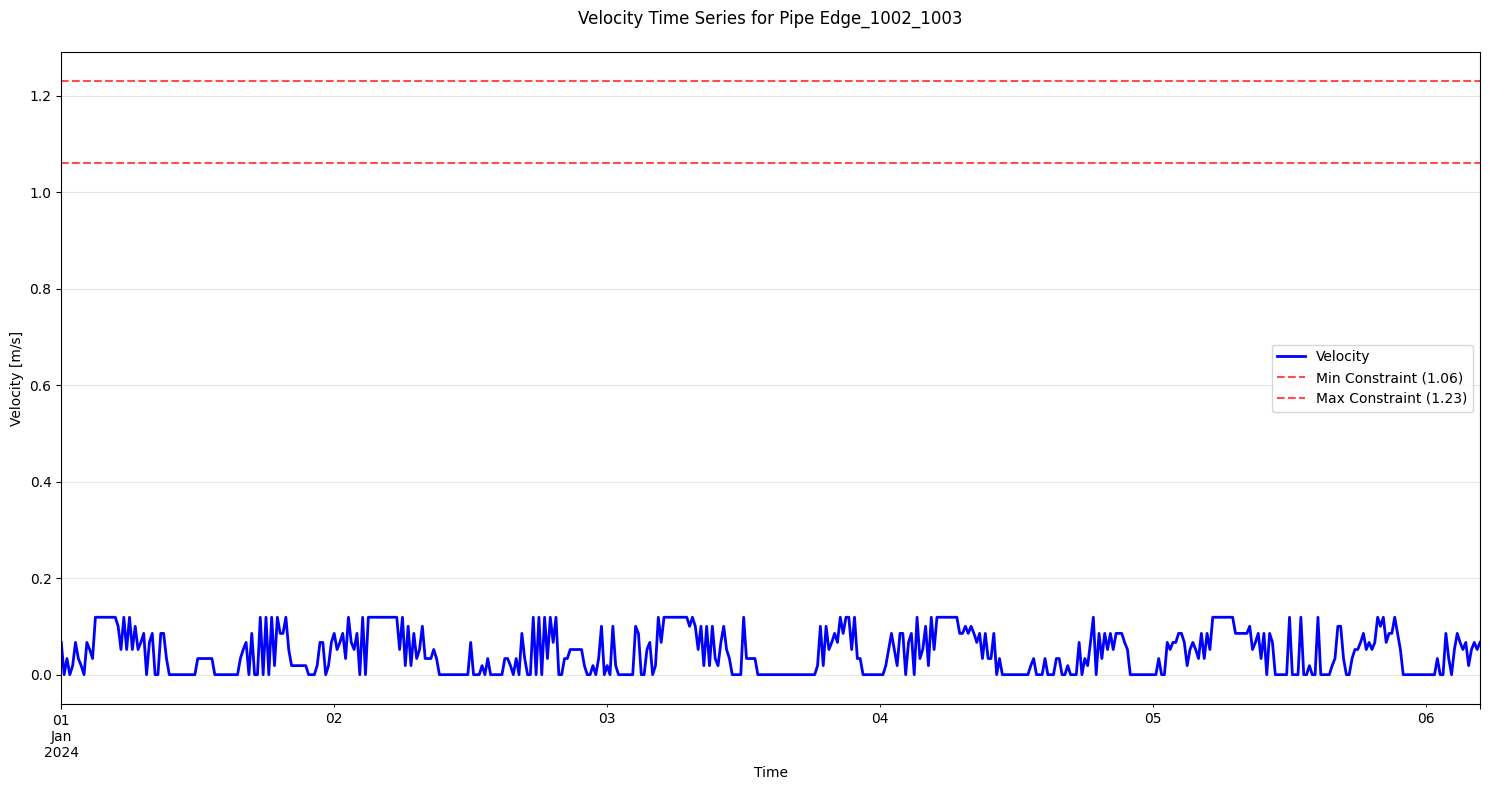

In [ ]:


# Get list of edges with velocity data
edges_with_velocity = []
for edge in analyzed_graph.edges:
    if 'velocity' in analyzed_graph.edges[edge]:
        edges_with_velocity.append(edge)

print(f"Found {len(edges_with_velocity)} edges with velocity data")

# Plot time series for first few pipes (or specific ones)
num_pipes_to_plot = min(3, len(edges_with_velocity))  # Plot max 3 pipes

for i, edge in enumerate(edges_with_velocity[:num_pipes_to_plot]):
    edge_data = analyzed_graph.edges[edge]
    
    # Prepare pipe data dictionary for the plotting function
    pipe_data = {
        'velocity': edge_data['velocity'],
        'name': f"Edge_{edge[0]}_{edge[1]}",  # Edge name
        'constraints': edge_data.get('constraints', {}),
    }
    
        
    save_path = os.path.join(scenario["output_dir"], f"velocity_constraint_time_series_{i+1}.png")

    velocity.plot_velocity_time_series(
        pipe_data=pipe_data,
        key="velocity",
        num_points=500,  # Adjust for performance (35041 to plot whole year)
        save_path=save_path
    )



In [45]:
analyzed_graph.edges[edge]["velocity"]

2024-01-01 00:00:00    0.067153
2024-01-01 00:15:00    0.000305
2024-01-01 00:30:00    0.033729
2024-01-01 00:45:00    0.000305
2024-01-01 01:00:00    0.019014
                         ...   
2024-12-30 23:00:00    0.067153
2024-12-30 23:15:00    0.000305
2024-12-30 23:30:00    0.033729
2024-12-30 23:45:00    0.000305
2024-12-31 00:00:00    0.019014
Freq: 15min, Name: networkModel.pipe10021004.port_a.m_flow, Length: 35041, dtype: float32

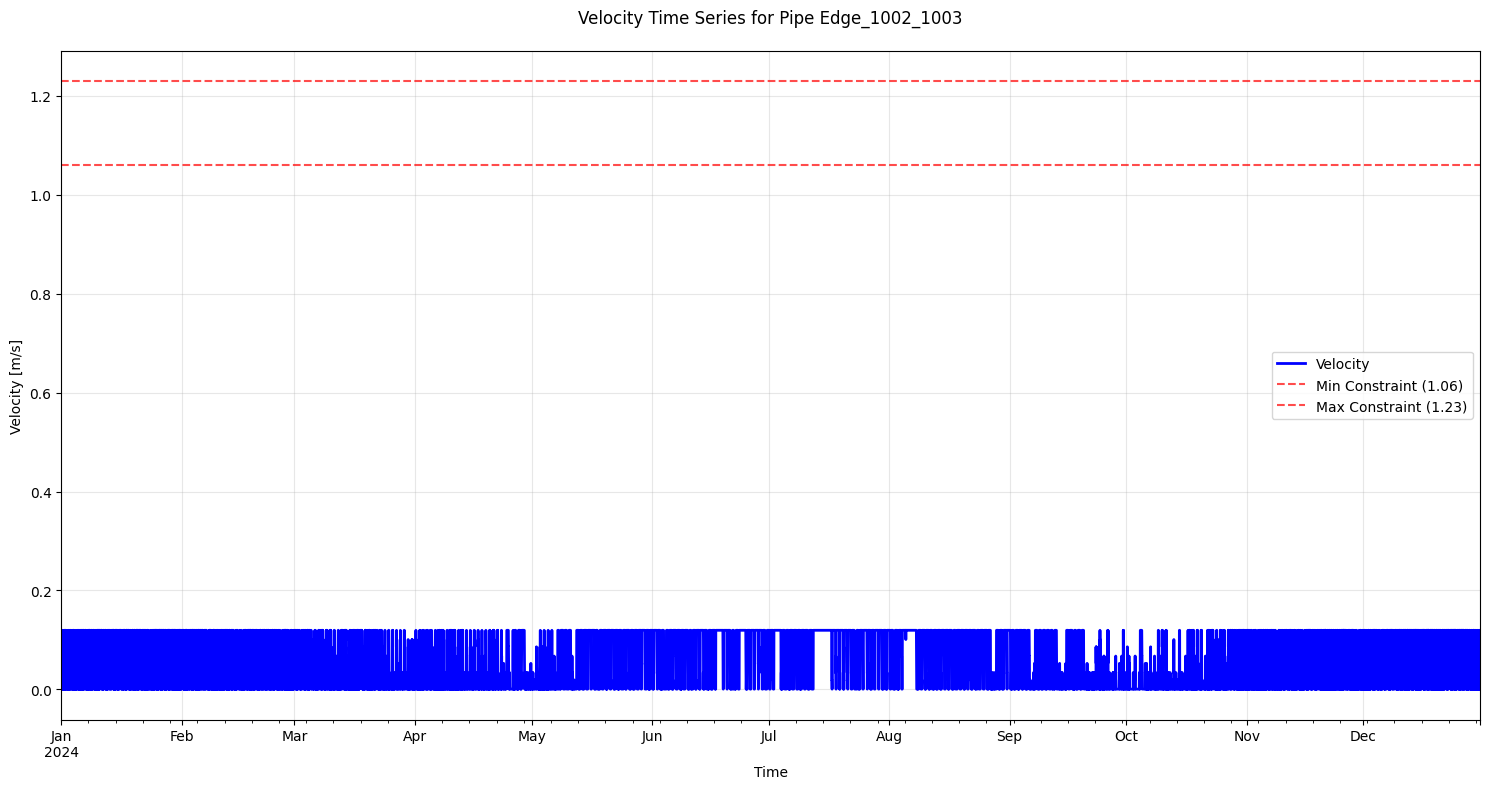

In [49]:
velocity.plot_velocity_time_series(
    pipe_data=pipe_data,
    key="velocity",
    num_points=35041,  # Adjust for performance
)